In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import pymc3 as pm
import arviz as az
from IPython.display import IFrame

In [2]:
az.style.use('arviz-darkgrid')

In [3]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

In [4]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False",});


<center><img src="img/logo_inst.png" width="700">
<br>
<br>
<br>
<br>
<h1 align="center">Exploratory Analysis of Bayesian models</h1> 
<h2 align="center">All models are wrong but some are useful</h2>



<br>
<br>
<br>
<br>
<br>

# ArviZ: Exploratory analysis of Bayesian models

<br>
<br>
<center><img src="img/logo_arviz.png" width=400></center>
<br>


* <font color = "gray"> Diagnoses of the quality of the inference </font>
* <font color = "gray"> Model criticism, including evaluations of both model assumptions and model predictions </font>
* Comparison of models, including model selection or model averaging
* <font color = "gray"> Preparation of the results for a particular audience </font>

## Predictive accuracy measures

* **within-sample accuracy**: The accuracy measured  with the data used to fit a model

* **out-of-sample accuracy** (AKA predictive accuracy): The accuracy of the model measured on data not used for fitting the model

* For any combinaton of data and models the within-sample accuracy will be, on average, smaller than the out-of-sample accuracy. 

* Using the within-sample accuracy could fool us to think that we have a better model than we thought

* In order to use the out-of-sample accuracy we need to be able to afford leaving aside a portion of the data not to fit the model but to test it.

* Alternatives:
    * Cross-validation: Empirical strategy based on dividing the available data into subsets that are used for fitting and evaluation in an alternated way 
    * Information criteria: Family of expressions to estimate the out-of-sample accuracy from the within-sample accuracy

## Akaike information criterion (AIC)

* This is a very well-known and widely used information criterion, especially for non-Bayesians, and is defined as:

$$AIC = -2 \sum_{i=1}^{n} \log p(y_i \mid \hat{\theta}_{mle}) + 2 pAIC $$


* Notice that the $\hat{\theta}_{mle}$ is a point estimation and not a distribution.

* The first term takes into account how well the model fits the data and the second term penalizes complex models.

## Widely applicable information criterion (WAIC)

* This is the fully Bayesian version of AIC. 

* Like with AIC, the widely applicable information criterion (WAIC) has two terms, one that measures how well the data fits the model and one penalizing complex models:

$$WAIC = -2 lppd + 2 p_{WAIC}$$

* How to compute each term is a little bit more involved that with AIC
    * Both terms are computing using the full posterior
    * Both terms are computed per observation

* From the practical point of view, we just need to know that we prefer lower values of WAIC

## Milk from primates

* We want to explore the composition of milk across several primate species.

* It is hypothesized that females from species of primates with larger brains produce more _nutritious_ milk

* We will use 3 variables
    * The proportion of neocortex compare to the total mass of the brain
    * the logarithm of the body mass of the mothers
    * The kilocalories per gram of milk (predicted variable)
    
* We will fit 3 different linear models:
    1. A model using only the neocortex variable
    2. A model using only the logarithm of the mass variable
    3. A model using both variables

[Statistical Rethinking](http://xcelab.net/rm/statistical-rethinking/)

In [8]:
d = pd.read_csv('datos/milk.csv')
d.iloc[:,1:] = d.iloc[:,1:] - d.iloc[:,1:].mean()
d.head()

,kcal.per.g,neocortex,log_mass
0,0.49,-0.123706,-0.831353
1,0.47,-0.030706,0.158647
2,0.56,-0.030706,0.181647
3,0.89,0.000294,-0.579353
4,0.92,0.012294,-1.885353


In [9]:
with pm.Model() as model_0:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', 10)
    
    mu = alpha + beta * d['neocortex']
    
    kcal = pm.Normal('kcal', mu=mu, sigma=sigma, observed=d['kcal.per.g'])
    trace_0 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


In [10]:
with pm.Model() as model_1:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', 10)
    
    mu = alpha + beta * d['log_mass']
    
    kcal = pm.Normal('kcal', mu=mu, sigma=sigma, observed=d['kcal.per.g'])
    
    trace_1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


In [11]:
with pm.Model() as model_2:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=2)
    sigma = pm.HalfNormal('sigma', 10)

    mu = alpha + pm.math.dot(beta, d[['neocortex','log_mass']].T)

    kcal = pm.Normal('kcal', mu=mu, sigma=sigma, observed=d['kcal.per.g'])

    trace_2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


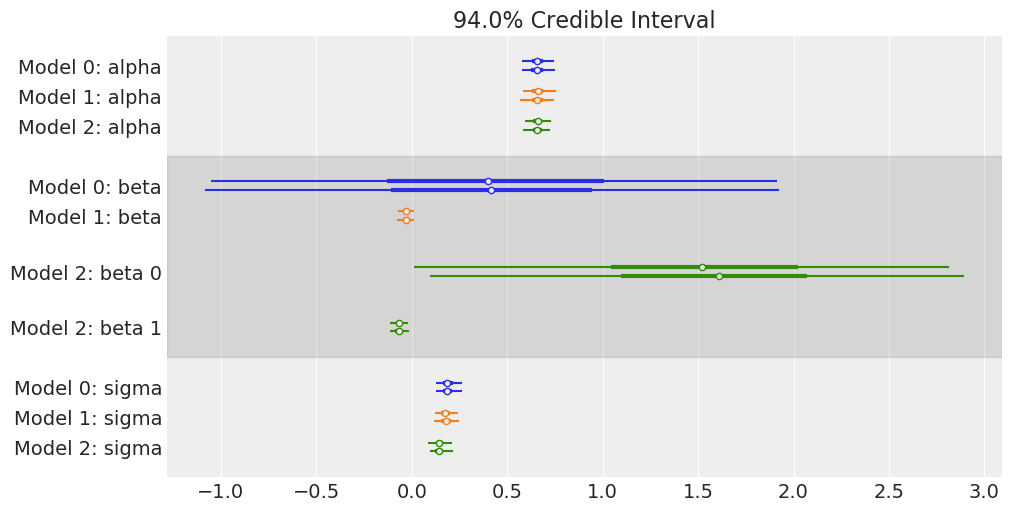

In [12]:
traces = [trace_0, trace_1, trace_2]
az.plot_forest(traces, figsize=(10, 5));

In [13]:
model_dict = dict(zip(['model_0', 'model_1', 'model_2'], traces))
comp = az.compare(model_dict)
comp

/home/osvaldo/proyectos/00_PyMC3/arviz/arviz/stats/stats.py:1185: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_2,0,-15.2788,2.72672,0,0.882804,3.18404,0,True,deviance
model_1,1,-8.8453,2.09019,6.43354,0.0475673,4.11252,2.17313,True,deviance
model_0,2,-7.26394,1.95418,8.01491,0.0696282,4.93125,4.21587,False,deviance


## Interpreting the comparison

* waic: contains the values of WAIC
* p_waic: the _effective number of parameters_ (do not take too seriously)
* d_waic: the relative difference between the value of WAIC for the top-ranked model and the value of WAIC for each model
* weight: relatively weight (or probability) of each model (within the compared models)
* se: the standard error of WAIC
* dse: the standard error of the differences between the value of WAIC for the top-ranked model and the value of WAIC for each model.
* warning: indicates that the computation of WAIC may not be reliable, this warning is based on an empirical determined cutoff value and need to be interpreted with caution

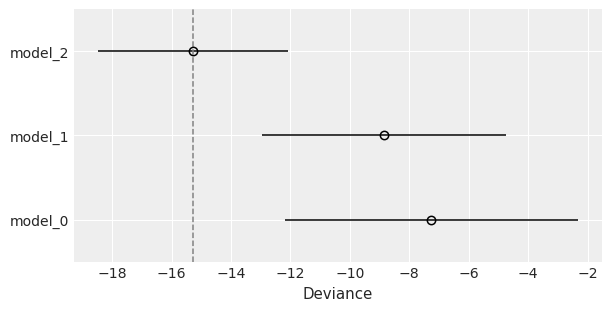

In [14]:
az.plot_compare(comp, insample_dev=False, plot_ic_diff=False);

In [12]:
waic_i_2 = az.waic(trace_2, pointwise=True).waic_i
waic_i_1 = az.waic(trace_1, pointwise=True).waic_i

/home/osvaldo/proyectos/00_PyMC3/arviz/arviz/stats/stats.py:1078: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


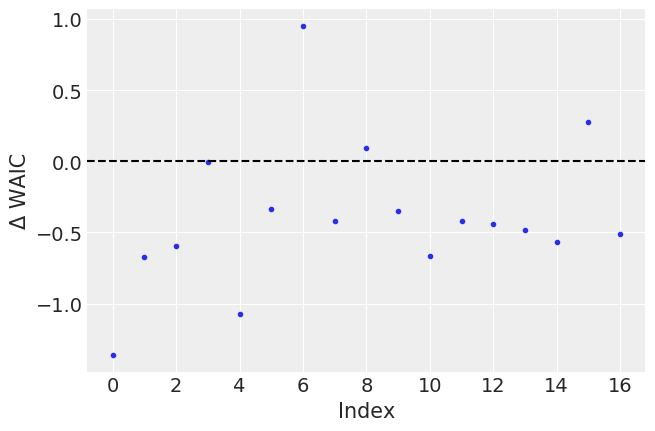

In [13]:
plt.plot(d.index, waic_i_2 - waic_i_1, 'C0.')
plt.axhline(0, color='k', ls='--')
plt.ylabel('Δ WAIC')
plt.xlabel('Index');

## Averaging models

* Instead of choosing the best model we can obtaining a meta-model by averaging all models
* We can use the weights obtained from `az.compare`
* We can use `pm.sample_posterior_predictive_w` to get predictions from the weighted models

In [14]:
# weighted predictions
ppc_w = pm.sample_posterior_predictive_w(traces, 1000, [model_0, model_1, model_2],
                        weights=comp.weight.sort_index(ascending=True))

# predictions from model 2
ppc_2 = pm.sample_posterior_predictive(trace_2, 1000, model_2,
                     progressbar=False)

100%|██████████| 1000/1000 [00:02<00:00, 403.81it/s]


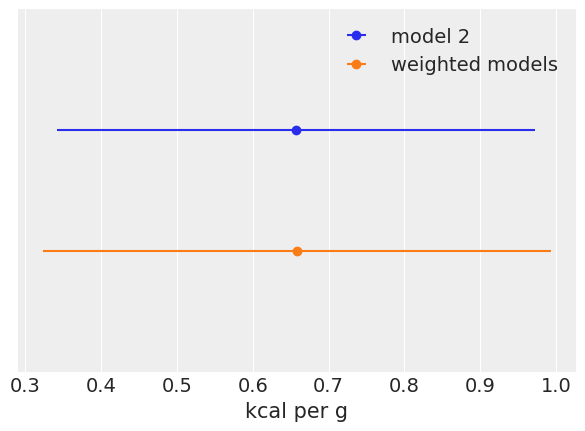

In [15]:
mean_w = ppc_w['kcal'].mean()
hpd_w = pm.hpd(ppc_w['kcal']).mean(0)

mean = ppc_2['kcal'].mean()
hpd = pm.hpd(ppc_2['kcal']).mean(0)

plt.errorbar(mean, 1, xerr=[[mean - hpd]], fmt='o', label='model 2')
plt.errorbar(mean_w, 0, xerr=[[mean_w - hpd_w]], fmt='o', label='weighted models')

plt.yticks([])
plt.ylim(-1, 2)
plt.xlabel('kcal per g')
plt.legend();

# Bayes factors

Let's rewrite Bayes' theorem, making  explicit the dependency of the inference on a given model $M$:

$$p(\theta \mid y, M_k) = {\frac {p(y \mid \theta, M_k)p(\theta \mid M_k)}{p(y \mid M_k)}}$$

The term in the denominator is known as marginal likelihood, the ratio of two maginal likelihoods is known as Bayes Factors:

$$BF = \frac{p(y \mid M_0)}{p(y \mid M_1)}$$

* when BF > 1, model 0 explains data better than model 1

* Using $p(y \mid M_k)$ to compare model is totally fine if all models have the same prior probability

* Otherwise, we have to compute the _posterior odds_:

$$\underbrace{\frac{p(M_0 \mid y)}{p(M_1 \mid y)}}_\text{posterior odds} = \underbrace{\frac{p(y \mid M_0)}{p(y \mid M_1)}}_\text{Bayes factors} \, \underbrace{\frac{p(\ M_0 \ )}{p(\ M_1 \ )}}_\text{prior odds}$$

## Some remarks about Bayes Factors


$$p(y \mid M_k) = \int_{\theta_k} p(y \mid \theta_k, M_k) p(\theta_k, M_k) d\theta_k$$


* The good: Models with more parameters have a larger penalization than models with fewer parameters. The intuitive reason is that the larger the number of parameters the more _spread_ the prior will be with respect to the likelihood.

* The bad: Computing the marginal likelihood is, generally, a hard task because it’s an integral of a highly variable function over a high dimensional parameter space. 

* The ugly: The marginal likelihood depends *sensitively* on the values of the priors

* One relatively simple way to compute BF with PyMC3 is by using the Sequential Monte Carlo sampler

In [16]:
coins = 30 # 300
heads = 9 # 90
y_d = np.repeat([0, 1], [coins-heads, heads])

with pm.Model() as model_BF_0:
    theta = pm.Beta('theta', 4, 8)
    y = pm.Bernoulli('y', theta, observed=y_d)
    trace_BF_0 = pm.sample(2500, step=pm.SMC())

with pm.Model() as model_BF_1:
    theta = pm.Beta('theta', 8, 4)
    y = pm.Bernoulli('y', theta, observed=y_d)
    trace_BF_1 = pm.sample(2500, step=pm.SMC())
    
model_BF_0.marginal_likelihood / model_BF_1.marginal_likelihood

Sample initial stage: ...
Stage: 0 Beta: 1.000 Steps: 25
Sample initial stage: ...
Stage: 0 Beta: 0.208 Steps: 25
Stage: 1 Beta: 0.649 Steps: 4
Stage: 2 Beta: 1.000 Steps: 3


11.588739818779212

## Information Criteria vs Bayes Factors

* Bayes factor are focused on which model is better (and the prior is part of the model)

* WAIC (and LOO) are focused on which model will give the better predictions (priors are taken into account indirectly)

## Exercises

1. compute WAIC and BF for models model_BF_0 and model_BF_1. Use (coins = 30, heads=9) and then (coins=300, heads = 90). Compare the differences in terms of WAIC when increasing the data and in terms of BF when increasing the data. 